# Learning FLPO

In this code, we will implement the hierarchical ML architecture to predict the parameters in the FLPO setup.

In [75]:
import torch
from VRP_Net_L import VRPNet_L
from matplotlib import pyplot as plt
import utils
import os
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import time
import LSE_net
from torch import optim
import importlib

# Loading the Data

In [76]:
torch.normal(mean=torch.tensor([0.3,0.3]), std=torch.tensor([0.1,0.1]))

tensor([0.5348, 0.3069])

In [77]:

seed=42;
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Running on: " , device)
num_drones = 100 # number of FLPO instances
num_facilities = 4
dim_ = 2
# START and END locations: no grads needed
nd_per_cluster = int(num_drones/2)
means1 = torch.tensor([[0.4,0.7]]).repeat(nd_per_cluster,1).unsqueeze(1).to(device)
std1 = torch.tensor([[0.05,0.05]]).repeat(nd_per_cluster,1).unsqueeze(1).to(device)
means2 = torch.tensor([[0.7,0.3]]).repeat(nd_per_cluster,1).unsqueeze(1).to(device)
std2 = torch.tensor([[0.05,0.05]]).repeat(nd_per_cluster,1).unsqueeze(1).to(device)
START_locs1 = torch.normal(mean=means1, std=std1)
START_locs2 = torch.normal(mean=means2, std=std2)
START_locs = torch.cat((START_locs1, START_locs2), axis=0)
END_locs   = torch.ones((num_drones, 1, dim_), requires_grad=False, device=device)#torch.rand(num_drones, 1, dim_, requires_grad=False, device=device)

# Facility locations: we want grads here
# We create a base tensor with requires_grad=True, then expand it
# F_base = torch.rand(1, num_facilities, dim_, requires_grad=True, device=device)
F_base = torch.mean(START_locs, dim=0).repeat(num_facilities, 1).unsqueeze(0).requires_grad_().to(device)
F_locs = F_base.expand(num_drones, -1, -1)  # view, shares grad with F_base
data = torch.cat((START_locs, F_locs, END_locs), dim=1)  # shape: (Nd, Nf+2, D)
print("Data Loaded.")


Running on:  cpu
Data Loaded.


### Compute n_routes from each drone

In [78]:
importlib.reload(utils)
n_drone_routes = torch.tensor(utils.num_flpo_routes(num_facilities, num_drones)[0], dtype=torch.float32).view(-1,1).to(device)
print(f"n_routes:\t{n_drone_routes.shape}\n{n_drone_routes}\nlog_n_routes:\t{n_drone_routes.shape}\n{torch.log(n_drone_routes)}")

n_routes:	torch.Size([100, 1])
tensor([[341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [341.],
        [

# Loading the VRP NET Module

In [79]:
hidden_dim = 32
num_layers_enc = 1
num_layers_dec = 1
num_heads = 8
torch.cuda.empty_cache()
vrp_net = VRPNet_L(dim_, hidden_dim, device, num_layers_enc, num_layers_dec, num_heads)
if torch.cuda.is_available():
    vrp_net.load_state_dict(torch.load('Saved models/POMO2025_04_12 00_54_260.6350972652435303best_model.pth',weights_only=True))
else:
    vrp_net.load_state_dict(torch.load('Saved models/POMO2025_04_12 00_54_260.6350972652435303best_model.pth',weights_only=False, map_location=torch.device('cpu')))
vrp_net.eval()

# for param in vrp_net.parameters():
#     param.requires_grad = False
print('VRP NET loaded on: ',vrp_net.device)
print(summary(vrp_net))

VRP NET loaded on:  cpu
Layer (type:depth-idx)                                                 Param #
VRPNet_L                                                               --
├─LinearAttnEncoder: 1-1                                               2,560
│    └─MultiheadAttention: 2-1                                         197,376
│    │    └─NonDynamicallyQuantizableLinear: 3-1                       65,792
│    └─Linear: 2-2                                                     768
│    └─Linear: 2-3                                                     8,224
│    └─LayerNorm: 2-4                                                  512
│    └─Dropout: 2-5                                                    --
│    └─ReLU: 2-6                                                       --
├─Decoder: 1-2                                                         --
│    └─TransformerDecoder: 2-7                                         --
│    │    └─ModuleList: 3-2                                       

# Loading lseNet

In [80]:
importlib.reload(LSE_net)
lse_data = torch.load('logSumExp_models/lse_2025_4_29__17_9_17.pth', weights_only=False)
n_inputs = lse_data['n_inputs']
n_outputs = lse_data['n_outputs']
layers = lse_data['layers']
weights = lse_data['model_state_dict']
io_scale = lse_data['io_scale']
lse_net = LSE_net.dnn(n_inputs, n_outputs, layers)
lse_net.to(device)
lse_net.load_state_dict(weights)
lse_net.eval()
for p in lse_net.parameters():
    p.requires_grad = False
print(f'n_inputs: {n_inputs}\nn_outputs: {n_outputs}\nlayers: {layers}\nio_scale: {io_scale}\nLSE_net:\n{summary(lse_net)}')

n_inputs: 3
n_outputs: 1
layers: [20, 20, 10]
io_scale: 1
LSE_net:
Layer (type:depth-idx)                   Param #
dnn                                      --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       (80)
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       (420)
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       (210)
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       (11)
Total params: 721
Trainable params: 0
Non-trainable params: 721


In [81]:
torch.tensor([10,10]).shape

torch.Size([2])

In [82]:
def logSumExp(D_tensor, beta):
    # with torch.no_grad():
    # print(D_tensor)
    D_min = torch.min(D_tensor, axis=1, keepdims=True)
    F = -1/beta * torch.log(torch.sum(torch.exp(-beta*(D_tensor - D_min.values)), axis=1, keepdims=True)) + 1/beta * torch.log(torch.tensor([D_tensor.shape[1]])) + D_min.values
    return F

### Pick a random variable matrix with iid entries of shape shape (a,b) between [r1, r2] at uniform using pytorch

In [83]:
# a = 3
# b = 2
# r1 = 0.5
# r2 = 10.0
# (r1 - r2) * torch.rand(a,b) + r2

In [84]:
s = time.time()
with torch.no_grad():
    # forward pass: no activations are saved for grad
    _, actions = vrp_net(data, mod='eval_greedy')
e = time.time()
actions.detach()
d_mins = utils.route_cost(data, actions)


In [85]:
d_mins.view(-1,1)

tensor([[0.5197],
        [0.4645],
        [0.4761],
        [0.4811],
        [0.5550],
        [0.4888],
        [0.5065],
        [0.5331],
        [0.4845],
        [0.5212],
        [0.5403],
        [0.5335],
        [0.5189],
        [0.5264],
        [0.5088],
        [0.5265],
        [0.5147],
        [0.5479],
        [0.4925],
        [0.4871],
        [0.5546],
        [0.5087],
        [0.5787],
        [0.5175],
        [0.5084],
        [0.5141],
        [0.5384],
        [0.5053],
        [0.5305],
        [0.5194],
        [0.5495],
        [0.5563],
        [0.5069],
        [0.4953],
        [0.4961],
        [0.5510],
        [0.5177],
        [0.5123],
        [0.4858],
        [0.5358],
        [0.4982],
        [0.5182],
        [0.5082],
        [0.4838],
        [0.5272],
        [0.4954],
        [0.5291],
        [0.4990],
        [0.5236],
        [0.5124],
        [0.5260],
        [0.4993],
        [0.6023],
        [0.5409],
        [0.5285],
        [0

In [86]:
with torch.no_grad():
    D_tensor = (d_mins.view(-1,1) - 1.0) * torch.rand(num_drones, int(n_drone_routes[0,0])) + 1.0
    F_tensor = logSumExp(D_tensor, beta=1e-4)
F_tensor 


tensor([[0.7677],
        [0.7311],
        [0.7429],
        [0.7362],
        [0.7811],
        [0.7370],
        [0.7528],
        [0.7598],
        [0.7268],
        [0.7637],
        [0.7753],
        [0.7720],
        [0.7421],
        [0.7562],
        [0.7546],
        [0.7651],
        [0.7506],
        [0.7912],
        [0.7503],
        [0.7412],
        [0.7703],
        [0.7519],
        [0.7924],
        [0.7640],
        [0.7670],
        [0.7620],
        [0.7836],
        [0.7446],
        [0.7592],
        [0.7684],
        [0.7684],
        [0.7789],
        [0.7503],
        [0.7495],
        [0.7580],
        [0.7746],
        [0.7535],
        [0.7667],
        [0.7448],
        [0.7630],
        [0.7456],
        [0.7657],
        [0.7638],
        [0.7454],
        [0.7619],
        [0.7518],
        [0.7696],
        [0.7615],
        [0.7580],
        [0.7556],
        [0.7644],
        [0.7427],
        [0.7986],
        [0.7803],
        [0.7564],
        [0

tensor([[0.7264]], grad_fn=<AddBackward0>)
tensor([ 0.7264,  0.4645, -2.0000])
tensor([ 0.7264,  0.4645, -1.9957])
tensor([ 0.7264,  0.4645, -1.9914])
tensor([ 0.7264,  0.4645, -1.9870])
tensor([ 0.7264,  0.4645, -1.9827])
tensor([ 0.7264,  0.4645, -1.9784])
tensor([ 0.7264,  0.4645, -1.9741])
tensor([ 0.7264,  0.4645, -1.9698])
tensor([ 0.7264,  0.4645, -1.9654])
tensor([ 0.7264,  0.4645, -1.9611])
tensor([ 0.7264,  0.4645, -1.9568])
tensor([ 0.7264,  0.4645, -1.9525])
tensor([ 0.7264,  0.4645, -1.9481])
tensor([ 0.7264,  0.4645, -1.9438])
tensor([ 0.7264,  0.4645, -1.9395])
tensor([ 0.7264,  0.4645, -1.9352])
tensor([ 0.7264,  0.4645, -1.9309])
tensor([ 0.7264,  0.4645, -1.9265])
tensor([ 0.7264,  0.4645, -1.9222])
tensor([ 0.7264,  0.4645, -1.9179])
tensor([ 0.7264,  0.4645, -1.9136])
tensor([ 0.7264,  0.4645, -1.9093])
tensor([ 0.7264,  0.4645, -1.9049])
tensor([ 0.7264,  0.4645, -1.9006])
tensor([ 0.7264,  0.4645, -1.8963])
tensor([ 0.7264,  0.4645, -1.8920])
tensor([ 0.7264,  0.4

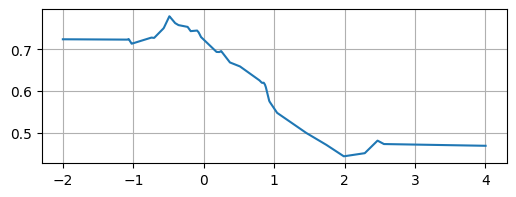

In [87]:
# b_arr = torch.tensor(lse_data['b_arr'], dtype=torch.float32)
# len_Darray = torch.tensor(lse_data['len_Darray'], dtype=torch.float32)
io_scale = lse_data['io_scale']
b_min = 0.01
b_max = 10000
b_grow = 1.01
b_array = utils.createBetaArray(b_min, b_max, b_grow).to(device)
drone_id = 1
FreeEnergy = []
betas = []

s = time.time()
with torch.no_grad():
    # forward pass: no activations are saved for grad
    _, actions = vrp_net(data, mod='eval_greedy')
e = time.time()
actions.detach()
d_mins = utils.route_cost(data, actions)[drone_id:drone_id+1]
d_array_est = (d_mins - 1.0) * torch.rand(1,int(n_drone_routes[drone_id,0])) + 1.0
Fmin_est = logSumExp(d_array_est, b_min)
print(Fmin_est)
# beta=b_min
for beta in b_array:

    torch.cuda.empty_cache()
    In = torch.tensor([
        Fmin_est.to(device),
        io_scale*d_mins,
        torch.log(torch.tensor([beta]))/torch.log(torch.tensor([10.0])).to(device)
    ])
    # update annealing parameter
    print(In)
    # print(In[2].detach().numpy())
    betas.append(In[2].detach().numpy())
    # print(betas)
    Out = lse_net(In)/io_scale - 0*(1/beta * torch.log(n_drone_routes[drone_id,0])).to(device)
    # print(beta, torch.log(torch.tensor([beta]))/torch.log(torch.tensor([10.0])), In, Out)
    # print(In)
    FreeEnergy.append(Out[0].detach().numpy())

    # beta = beta * b_grow
    
    
plt.figure(figsize=(6,2))
plt.plot(betas, FreeEnergy)
plt.grid()
plt.show()

### Compute an estimate of free energy at b_min for all drones using d_min

In [88]:
num_epochs = 400;
optimizer = optim.Adam([F_base], lr=1e-3)
# b_arr = torch.tensor(lse_data['b_arr'], dtype=torch.float32)
# len_Darray = torch.tensor(lse_data['len_Darray'], dtype=torch.float32)
io_scale = lse_data['io_scale']
b_min = 1e-4
b_max = 1e-4
b_grow = 2
b_array = utils.createBetaArray(b_min, b_max, b_grow).to(device)
torch.autograd.set_detect_anomaly(True)
# beta=b_min
for beta in b_array:
    print(f"beta:{beta:.3e}")
    for epoch in range(num_epochs):
        s = time.time()
        with torch.no_grad():
            # forward pass: no activations are saved for grad
            _, actions = vrp_net(data, mod='eval_greedy')
        e = time.time()
        actions.detach()
        d_mins = utils.route_cost(data, actions)
        # print('here0')
        with torch.no_grad():
            D_bmin_tensor = (d_mins.view(-1,1) - 1.0) * torch.rand(num_drones, int(n_drone_routes[0,0])) + 1.0
            # print('here1')
            Fmin_tensor = logSumExp(D_bmin_tensor, beta=b_min).to(device)
        # print('here2')
        torch.cuda.empty_cache()

        In = torch.cat((
            Fmin_tensor,
            io_scale*d_mins.view(-1,1), 
            torch.ones((num_drones,1)).to(device)*torch.log(torch.tensor([beta]))/torch.log(torch.tensor([10.0])).to(device).to(device)), axis=1) #, torch.ones((num_drones,1)).to(device)*b_min.to(device)),axis=1)
        # print(In)
        Out = lse_net(In)/io_scale + d_mins.view(-1,1) #- (1/beta * torch.log(n_drone_routes)).to(device) 
        FreeEnergy = torch.mean(Out)
        
        # print(torch.norm(data))
        optimizer.zero_grad()
        FreeEnergy.backward()
        optimizer.step()
        # perturb and update facility location data for each drone
        std1 = torch.tensor([[0.05,0.05]]).repeat(nd_per_cluster,1).unsqueeze(1).to(device)
        with torch.no_grad():
            F_base += torch.normal(mean=torch.zeros(1,num_facilities,dim_), std=0.0001*torch.ones(1,num_facilities,dim_)).to(device)
        # print(F_base)
        F_locs = F_base.expand(num_drones, -1, -1)
        # print(F_locs)
        data = torch.cat((START_locs, F_locs, END_locs), dim=1)
        if epoch % 50 == 0 or epoch == num_epochs-1:
            print(f"\tEpoch: {epoch}\tVRP_runtime: {e-s:.2f}s\tFreeEnergy: {FreeEnergy:.2f}\tF_Grad: {torch.max(torch.abs(F_base.grad)):.3e}\td_min_mean: {torch.mean(d_mins):.2f}")
    # update annealing parameter
    beta = beta * b_grow
    


beta:1.000e-04
	Epoch: 0	VRP_runtime: 0.03s	FreeEnergy: 1.27	F_Grad: 9.160e-01	d_min_mean: 0.52
	Epoch: 50	VRP_runtime: 0.01s	FreeEnergy: 1.12	F_Grad: 7.841e-01	d_min_mean: 0.42
	Epoch: 100	VRP_runtime: 0.02s	FreeEnergy: 1.02	F_Grad: 6.493e-01	d_min_mean: 0.35
	Epoch: 150	VRP_runtime: 0.02s	FreeEnergy: 0.94	F_Grad: 5.481e-01	d_min_mean: 0.30
	Epoch: 200	VRP_runtime: 0.03s	FreeEnergy: 0.89	F_Grad: 4.486e-01	d_min_mean: 0.27
	Epoch: 250	VRP_runtime: 0.02s	FreeEnergy: 0.85	F_Grad: 3.595e-01	d_min_mean: 0.24
	Epoch: 300	VRP_runtime: 0.02s	FreeEnergy: 0.82	F_Grad: 2.787e-01	d_min_mean: 0.22
	Epoch: 350	VRP_runtime: 0.02s	FreeEnergy: 0.81	F_Grad: 2.133e-01	d_min_mean: 0.21
	Epoch: 399	VRP_runtime: 0.02s	FreeEnergy: 0.79	F_Grad: 1.596e-01	d_min_mean: 0.21


# Plotting some results

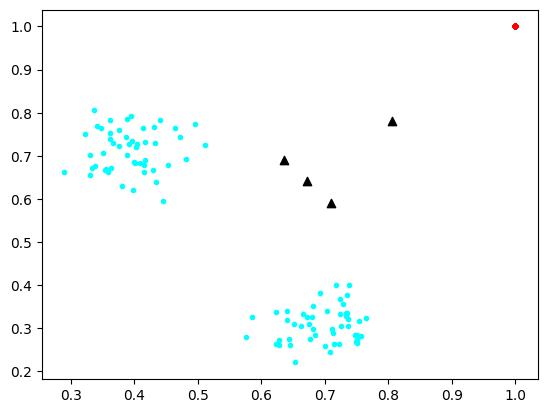

In [89]:
start_locs = START_locs.squeeze(1).cpu().numpy()
plt.scatter(start_locs[:,0],start_locs[:,1],color='cyan',marker='.')
end_locs = END_locs.squeeze(1).cpu().numpy()
plt.scatter(end_locs[:,0],end_locs[:,1],color='red',marker='.')
f_locs = F_base.squeeze(0).detach().cpu().numpy()
plt.scatter(f_locs[:,0],f_locs[:,1],color='black',marker='^')

# Calculating the gradients

The output of this block shoud be dF/dy

First calculate $\frac{\partial F}{\partial d_{min}}$ (code in progress)

In [63]:
# fix beta
b = np.random.choice(b_arr)
d_mins_torch = torch.tensor(d_mins, dtype=torch.float32, requires_grad=True).view(-1,1)
const_bmin = -io_scale/b_arr[0] * np.log(len_Darray) * torch.ones(len(d_mins), dtype=torch.float32).view(-1,1)
const_b = b * torch.ones(len(d_mins), dtype=torch.float32).view(-1,1)
In = torch.concatenate((const_bmin, d_mins_torch, const_b), axis=1)
Out = lse_net(In)
# print(Out)
Out[0].retain_grad()
Out[0].backward()
d_mins_torch.grad

/var/folders/sh/ndxykdmj1q9cwr2kpvkvcbs80000gn/T/ipykernel_89473/1274708057.py:11: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  d_mins_torch.grad


# Running CLF to determin Y

The GD code here

# Closing the Beta Loop for Annealing

In [30]:
import torch

x = torch.arange(20)  # Just an example tensor: [0, 1, 2, ..., 19]

# Create a mask to skip every 5th element
mask = torch.zeros(len(x), dtype=bool)
mask[0::5] = True  # Set every 5th element to False
print(mask)
result = x[mask]

print("Original:", x)
print("Filtered:", result)


tensor([ True, False, False, False, False,  True, False, False, False, False,
         True, False, False, False, False,  True, False, False, False, False])
Original: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])
Filtered: tensor([ 0,  5, 10, 15])
